In [1]:
# IMPORTING PACKAGES

import pandas as pd
import numpy as np
import datetime
from datetime import date
import time
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from termcolor import colored as cl # text customization
from yellowbrick.cluster import KElbowVisualizer
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.cluster import Birch
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import DBSCAN


In [2]:
orders=pd.read_table('C:/Users/faidr/Downloads/orders.csv',sep=',')

In [3]:
#Extracting the breakfast orders
breakfast_orders=orders[orders['cuisine']=='Breakfast']
bf_orders=breakfast_orders.reset_index()
bf_orders.describe()

,index,order_id,user_id,amount
count,207963.000000,2.079630e+05,2.079630e+05,207963.000000
mean,103981.000000,7.305541e+12,2.959549e+11,5.093825
std,60033.891353,5.981107e+10,2.053375e+11,3.248764
min,0.000000,7.202719e+12,1.103620e+08,0.400000
25%,51990.500000,7.251892e+12,1.271327e+11,3.100000
50%,103981.000000,7.307995e+12,2.450251e+11,4.400000
75%,155971.500000,7.362920e+12,4.922339e+11,6.000000
max,207962.000000,7.404765e+12,6.855662e+11,150.000000


### Analyze data per user

In [4]:
users=pd.pivot_table(bf_orders,index=['user_id'],
                     aggfunc={'amount':np.mean,'order_id': 'count'})
users=users.reset_index()
users.describe()
users_features=users.drop(columns='user_id')
users_features.columns=['avg_order_value','number_of_orders']

In [5]:
users_features.describe()

,avg_order_value,number_of_orders
count,55834.000000,55834.000000
mean,5.838862,3.724666
std,3.435396,4.956646
min,0.500000,1.000000
25%,3.866667,1.000000
50%,5.000000,2.000000
75%,6.900000,4.000000
max,150.000000,114.000000


### Detect and Remove Outliers

In [6]:
q_low_orders = users_features['number_of_orders'].quantile(0.01)
q_hi_orders = users_features['number_of_orders'].quantile(0.99)
q_low_value = users_features['avg_order_value'].quantile(0.01)
q_hi_value = users_features['avg_order_value'].quantile(0.99)

In [7]:
outliers=users_features[(users_features['number_of_orders']>q_hi_orders) | 
                        (users_features['number_of_orders']<q_low_orders)|
                        (users_features['avg_order_value']<q_low_value)|
                        (users_features['avg_order_value']>q_hi_value)].sort_values(by='number_of_orders',ascending=False)

In [8]:
perc_outliers=(len(outliers)/len(users_features))*100
print('% outliers: ',"%.2f" % perc_outliers ,'%')


% outliers:  2.94 %


#### Extracting outliers

In [9]:
users_features_cl=users_features[(users_features['number_of_orders']<=q_hi_orders) & 
                        (users_features['number_of_orders']>=q_low_orders)&
                        (users_features['avg_order_value']>=q_low_value)&
                        (users_features['avg_order_value']<=q_hi_value)]
users_features_cl=users_features_cl.reset_index()
users_features_cl=users_features_cl[['avg_order_value','number_of_orders']]

In [10]:
users_features_cl.describe()

,avg_order_value,number_of_orders
count,54194.000000,54194.000000
mean,5.710077,3.458593
std,2.760818,3.907322
min,1.800000,1.000000
25%,3.900000,1.000000
50%,5.000000,2.000000
75%,6.860000,4.000000
max,18.320000,25.000000


C:\Users\faidr\.anaconda\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


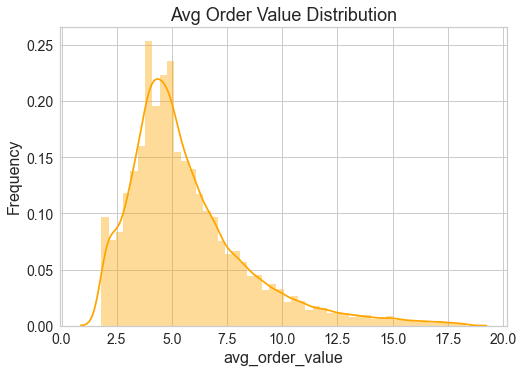

In [11]:
sns.distplot(users_features_cl['avg_order_value'], 
            color = 'orange')
plt.title('Avg Order Value Distribution', 
          fontsize = 18)
plt.xlabel('avg_order_value', 
           fontsize = 16)
plt.ylabel('Frequency', 
           fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

C:\Users\faidr\.anaconda\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


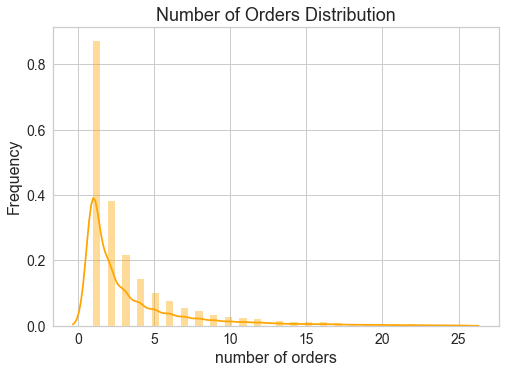

In [12]:
sns.distplot(users_features_cl['number_of_orders'], 
            color = 'orange')
plt.title('Number of Orders Distribution', 
          fontsize = 18)
plt.xlabel('number of orders', 
           fontsize = 16)
plt.ylabel('Frequency', 
           fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

C:\Users\faidr\.anaconda\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


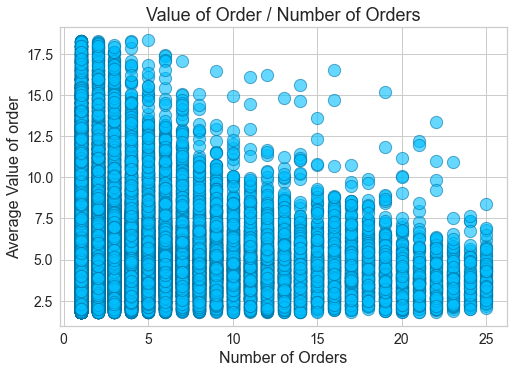

In [13]:
sns.scatterplot('number_of_orders','avg_order_value', 
               data = users_features_cl, 
               color = 'deepskyblue', 
               s = 150, 
               alpha = 0.6, 
               edgecolor = 'b')
plt.title('Value of Order / Number of Orders', 
          fontsize = 18)
plt.xlabel('Number of Orders', 
           fontsize = 16)
plt.ylabel('Average Value of order', 
           fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.show()

In [14]:
X=users_features_cl.values

### KElbowVisualizer

The KElbowVisualizer implements the “elbow” method to select the optimal number of clusters by fitting the model with a range of values for k.<br>
If the line chart resembles an arm, then the “elbow” (the point of inflection on the curve) is a good indication that the underlying model fits best at that point. In the visualizer “elbow” will be annotated with a dashed line. <br>
https://www.scikit-yb.org/en/latest/api/cluster/elbow.html

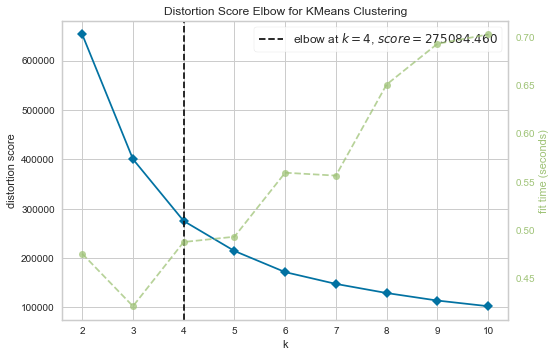

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [15]:
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(X)
Elbow_M.show()

### K Means clustering

K-means is a centroid-based clustering algorithm, where we calculate the distance between each data point and a centroid to assign it to a cluster. The goal is to identify the K number of groups in the dataset. <br>
It is an iterative process of assigning each data point to the groups and slowly data points get clustered based on similar features. The objective is to minimize the sum of distances between the data points and the cluster centroid, to identify the correct group each data point should belong to. <br>
https://neptune.ai/blog/k-means-clustering

In [16]:
clusters = 4
model_kmeans = KMeans(init = 'k-means++', 
               n_clusters = clusters, 
               n_init = 50)
model_kmeans.fit(X)

labels_kmeans = model_kmeans.labels_

In [17]:
users_features_cl['k_means_clusters']=labels_kmeans
users_features_cl.sort_values(by='avg_order_value')

,avg_order_value,number_of_orders,k_means_clusters
33855,1.80,2,0
8513,1.80,2,0
11072,1.80,4,0
11658,1.80,2,0
3126,1.80,21,3
...,...,...,...
8449,18.30,1,2
44893,18.30,1,2
47188,18.30,1,2
2205,18.30,1,2


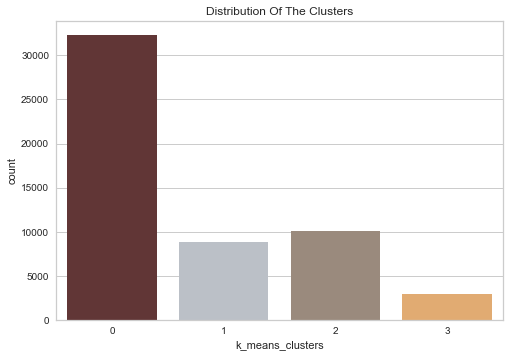

In [18]:
#Plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=users_features_cl["k_means_clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

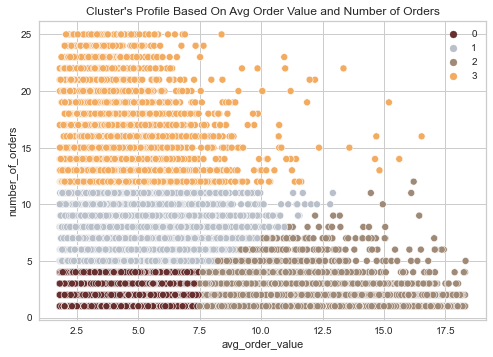

In [19]:
pl = sns.scatterplot(data = users_features_cl,x=users_features_cl['avg_order_value'],
                     y=users_features_cl['number_of_orders'],hue=users_features_cl["k_means_clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Avg Order Value and Number of Orders")
plt.legend()
plt.show()

### DBSCAN Clustering

DBSCAN stands for density-based spatial clustering of applications with noise. It is able to find arbitrary shaped clusters and clusters with noise (i.e. outliers). The main idea behind DBSCAN is that a point belongs to a cluster if it is close to many points from that cluster. <br>
https://towardsdatascience.com/dbscan-clustering-explained-97556a2ad556

In [24]:
clusters_DBSCAN = DBSCAN(eps=3, min_samples=4).fit(X)

In [25]:
users_features_cl['DBSCAN_clusters']=clusters_DBSCAN.labels_

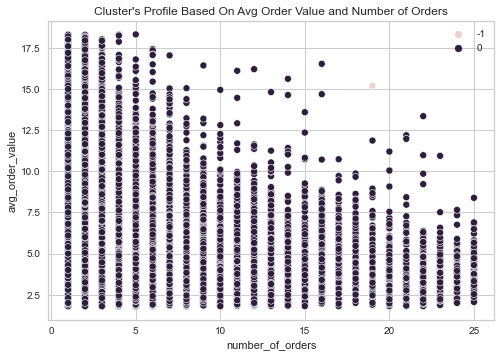

In [26]:
pl = sns.scatterplot(data = users_features_cl,x=users_features_cl['number_of_orders'], 
                     y=users_features_cl['avg_order_value'],hue=users_features_cl["DBSCAN_clusters"])
pl.set_title("Cluster's Profile Based On Avg Order Value and Number of Orders")
plt.legend()
plt.show()

### Birch Clustering

BIRCH is a scalable clustering method based on hierarchy clustering and only requires a one-time scan of the dataset, making it fast for working with large datasets. This algorithm is based on the CF (clustering features) tree. In addition, this algorithm uses a tree-structured summary to create clusters. <br>
https://analyticsindiamag.com/guide-to-birch-clustering-algorithmwith-python-codes/

In [27]:
model = Birch(branching_factor = 50, n_clusters = 4, threshold = 1.5)

In [28]:
model.fit(X)

Birch(n_clusters=4, threshold=1.5)

In [29]:
clusters_Birch = model.predict(X)

In [30]:
users_features_cl['Birch_clusters']=clusters_Birch

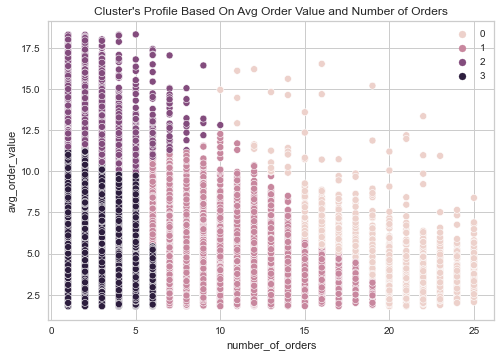

In [37]:
pl = sns.scatterplot(data = users_features_cl,x=users_features_cl['number_of_orders'], 
                     y=users_features_cl['avg_order_value'],hue=users_features_cl["Birch_clusters"])
pl.set_title("Cluster's Profile Based On Avg Order Value and Number of Orders")
plt.legend()
plt.show()

### Evaluation of Models

Since the ground truth labels are not known, the Calinski-Harabasz index (sklearn.metrics.calinski_harabasz_score) - also known as the Variance Ratio Criterion - can be used to evaluate the model, where a higher Calinski-Harabasz score relates to a model with better defined clusters.

The index is the ratio of the sum of between-clusters dispersion and of within-cluster dispersion for all clusters (where dispersion is defined as the sum of distances squared) <br>
https://towardsdatascience.com/three-performance-evaluation-metrics-of-clustering-when-ground-truth-labels-are-not-available-ee08cb3ff4fb

#### K-means

In [32]:
metrics.calinski_harabasz_score(X, labels_kmeans)

63399.84607842332

#### DBSCAN

In [33]:
metrics.calinski_harabasz_score(X, clusters_DBSCAN.labels_)

14.490740569394868

#### Birch

In [34]:
metrics.calinski_harabasz_score(X, clusters_Birch)

38791.60990190061

We will use the K-means clustering algorithm since it has the best perfomance and requires less run time.

### Profiling

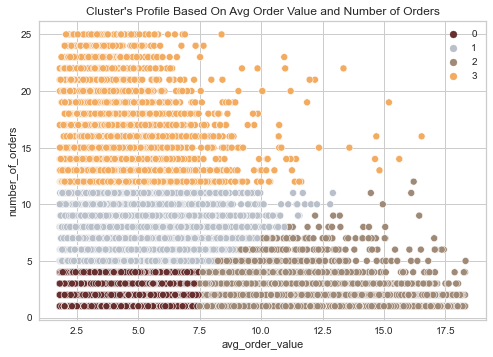

In [36]:
pl = sns.scatterplot(data = users_features_cl,x=users_features_cl['avg_order_value'],
                     y=users_features_cl['number_of_orders'],hue=users_features_cl["k_means_clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Avg Order Value and Number of Orders")
plt.legend()
plt.show()

In [41]:
print(pd.pivot_table(users_features_cl, index='k_means_clusters',aggfunc={'avg_order_value':np.mean, 'number_of_orders':np.mean}))

                  avg_order_value  number_of_orders
k_means_clusters                                   
0                        4.661636          1.819662
1                        4.790145          7.104289
2                       10.263517          1.784133
3                        4.412756         16.143727


#### Cluster 0: 
Customers with low spending and low number of orders. <br>
The customers made 1-5 orders in January and spend less that 7.5 euro in average. 

#### Cluster 1:
Customers with intermediate number of orders in January but low order value.<br>
The customers made 5-11 orders in January with 0.5-12 euros

#### Cluster 2:
Customers with low number of orders but high average order value.<br>
The customers made 1-8 orders in January with 7.5-18 euros


#### Cluster 3: 
Customers with high number of orders but low average order value.<br>
The customers made 11-25 orders in January and spend 0.5-10 euros.


The table below shows the value of each cluster, calculated based on the sum of the multiplication of the average order value with the number of orders for each user.

In [35]:
cluster_value=[(users_features_cl['avg_order_value'][i]*users_features_cl['number_of_orders'][i]) for i in range(0,len(users_features_cl))]
users_features_cl['cluster_value']=cluster_value
pd.pivot_table(users_features_cl,index='k_means_clusters', aggfunc={'cluster_value':np.sum})

,cluster_value
k_means_clusters,
0,275517.61
1,301481.60
2,183108.42
3,208482.55


Cluster 1 is the most valuable users target segment.

### Future Work

Study the users frequency on orders per week.

#Extracting date from order_timestamp
order_dates=[order.split()[0] for order in orders['order_timestamp']]
#Converting it to date
order_dates=[datetime.datetime.strptime(date, "%Y-%m-%d") for date in order_dates ]
#Extracting month from dates
orders_per_week=[int((date.day)/7) for date in order_dates]
orders['orders_per_week']=orders_per_week
orders['orders_per_week'].unique()